In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from subprocess import Popen, PIPE

# Path to the PULSE executable. This example requires the fp64 version of PULSE
PULSE_PATH = "../../pulse.exe"

# Pulse loads local resources, so we need to set the working directory to the location of the executable
PULSE_CWD = os.path.dirname( os.path.realpath(PULSE_PATH) )

# Path to the data folder relative to PULSE_CWD
DATA_PATH = "examples/example_2/data/"

# Create results and load folders
result_path = os.path.join(PULSE_CWD, DATA_PATH, "results")
load_path = os.path.join(PULSE_CWD, DATA_PATH, "load")

# Create Target Directories
os.makedirs(result_path, exist_ok=True)
os.makedirs(load_path, exist_ok=True)

# System Parameters
grid_size = 1802                # Grid Size, int this case 1802x1802
x_max = 180                     # mum; Maximum Distance in one direction, meaning the grid will be from -90mum to 90mum
effective_mass = 5.864E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.005                 # Polariton Loss Rate
gamma_r = 0                     # Reservoir Loss Rate
R = 0                           # Condensation Rate
g_c = 2E-6                      # Polariton-Polariton Coupling
g_r = 0                         # Polariton-Reservoir Coupling
t_step = 0.02                  # ps; Time step of the simulation

# Pump Parameters
pump_amplitude = 5.6856                 # meV; Pump Amplitude
pump_frequency = -5.68178730684262      # Hz; Pump Frequency

# Additional Parameters not required by PULSE:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Matrix Generation

While PULSE can also generate spacial shapes via its envelope syntax, it is usually beneficial to pre-generate all required inputs. This way, we can plot and verify the inputs beforehand.

We generate an X-Y Meshgrid using numpy, fill the pump and potential matrices and plot them.


In [2]:
# X-Y Meshgrid
x = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
y = np.linspace(-x_max/2, x_max/2, grid_size, endpoint=False)
X, Y = np.meshgrid(x, y)

# Load Matrices
initial_state = np.loadtxt(os.path.join(load_path, "wavefunction_plus.txt"), comments="#")
potential = np.loadtxt(os.path.join(load_path, "potential_plus.txt"), comments="#")

# The shape of the input matrices is N^2 x N. the first N rows are the real part, the second N rows are the imaginary part
initial_state = initial_state[:grid_size] + 1j*initial_state[grid_size:]
potential = potential[:grid_size] + 1j*potential[grid_size:]

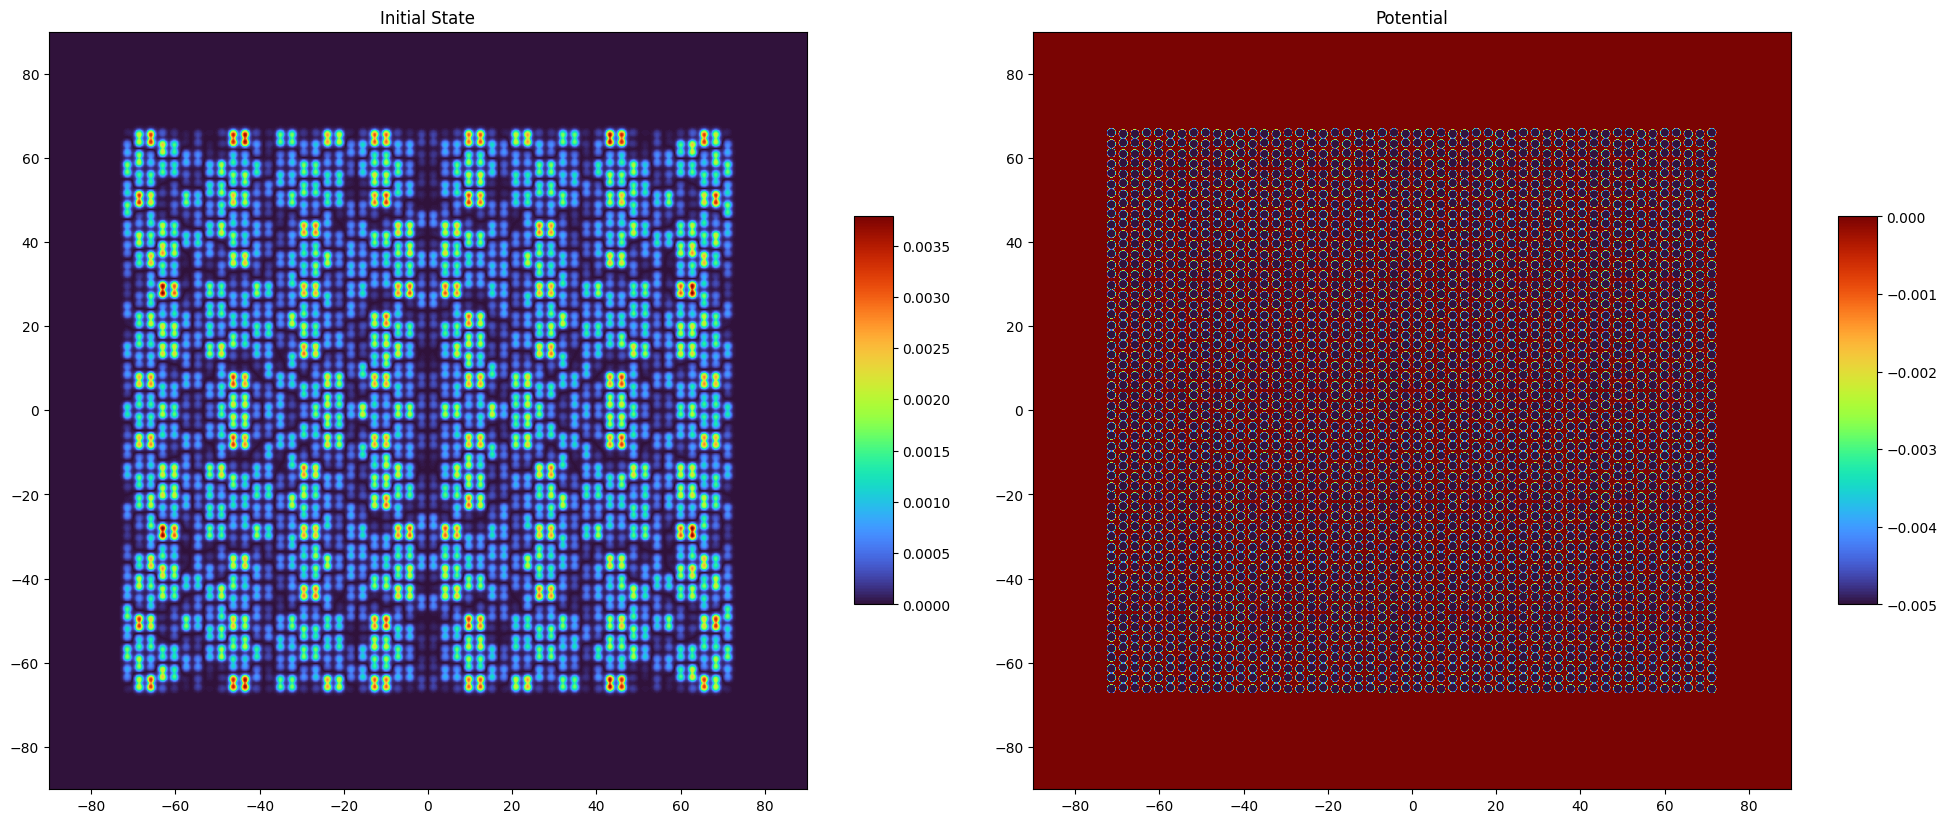

In [3]:
# Plot the pump and potential
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plt_init = ax1.pcolormesh(X,Y,np.abs(initial_state), cmap="turbo")
ax1.set_title("Initial State")
plt_pot = ax2.pcolormesh(X,Y,np.real(potential), cmap="turbo")
ax2.set_title("Potential")

# Colorbars
fig.colorbar(plt_init, shrink=0.4, aspect=10)
fig.colorbar(plt_pot, shrink=0.4, aspect=10)
[ax.set_aspect("equal") for ax in (ax1,ax2)]

plt.tight_layout()

# Execute Pulse

We create a function to generate the PULSE compatible commandline runstring and execute a test calculation.

We also plot the test calculation. The density for the given set of parameters should approach zero.


In [14]:
# Runstring generator
def generate_runstring( *, t_max: float ):
    # Generate Load Path relative to PULSE_CWD
    relative_result_path = os.path.relpath(result_path, PULSE_CWD).replace("\\", "/")
    relative_load_path = os.path.relpath(load_path, PULSE_CWD).replace("\\", "/")
    runstring = f"{PULSE_PATH} "
    runstring += f"--path {relative_result_path} "      # Set the output path
    runstring += f"--loadFrom {relative_load_path} "    # Set the load path
    runstring += "--input all "                         # Set the input to all
    runstring += f"--N {grid_size} {grid_size} "        # Set the grid size in points
    runstring += f"--L {x_max} {x_max} "                # Set the grid size in mum
    runstring += f"--meff {effective_mass} "            # Set the effective mass
    runstring += f"--tmax {t_max} "                     # Set the end time
    runstring += "--outEvery 1 "                        # Set sample rate to 0.5ps
    runstring += "--fftEvery 1 "                        # Set the FFT sample rate to 1ps
    runstring += f"--gc {g_c} "                         # Set the coupling constants
    runstring += f"--gr {g_r} "                         # Set the coupling constants
    runstring += f"--R {R} "                            # Set the condensation rate
    runstring += f"--gammaR {gamma_r} "                 # Set the reservoir loss rate
    runstring += f"--gammaC {gamma_c} "                 # Set the polariton loss rate
    runstring += "--subgrids 2 -noReservoir "                        # Set the number of subgrids
    # Add constant resonant pump with oscillation
    runstring += f"--pulse {pump_amplitude*0.01} add {15*x_max} {15*x_max} 0 0 plus 1 none gauss+noDivide time iexp 0 50E6 {pump_frequency} " 
    # Add the potential
    runstring += f"--potential load {os.path.join(relative_load_path, 'potential_plus.txt')} 1 add plus "
    runstring += "--output wavefunction,max "
    return runstring

In [15]:
# Test Calculation, Execute PULSE
runstring = generate_runstring( t_max = 600 )
# Call the runstring and wait for the subprocess to finish
process = Popen( runstring.split(), stdout=PIPE, stderr=PIPE, cwd = PULSE_CWD )
stdout, stderr = process.communicate()
# Print the output
print(stdout.decode("utf-8"))

---------------------------- Inputting System Parameters --------------------------
[ i ] Subgrid Configuration: 2x2
[ i ] Subgrid Size: 901x901
[ i ] Halo Size for iterator 'rk4' = 4
[ i ] Parsing envelope 'potential'
[ i ] Queuing envelope 'potential' to be loaded from file: 'examples/example_2/data/load\potential_plus.txt'
[ v ] Added Spacial Component to Envelope 'potential'
[ i ] Parsing envelope 'pulse'
[ v ] Added Spacial Component to Envelope 'pulse'
[ v ] Added Temporal Component 'iexp' to Envelope 'pulse'
[ i ] Successfully created directory 'examples/example_2/data/results/'
[ i ] Creating Solver...
-------------------- Initializing Host and Device Matrices ------------------------
[ i ] Allocating 24.994659 MB for 1x1802x1802 device matrix 'wavefunction_plus' with halo 4 and 4 total subgrids, total allocated device space: 24.994659 MB.
[ i ] Full grid buffer for size 3247204 not found, creating new buffer.
[ i ] Allocating 24.994659 MB for 1x1802x1802 device matrix 'reservo

### Plotting
PULSE saves outputs using one row per line, saving real parts first. This means, for our 200x200 complex matrices, PULSE will output a textfile containing a 400x200 (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`.

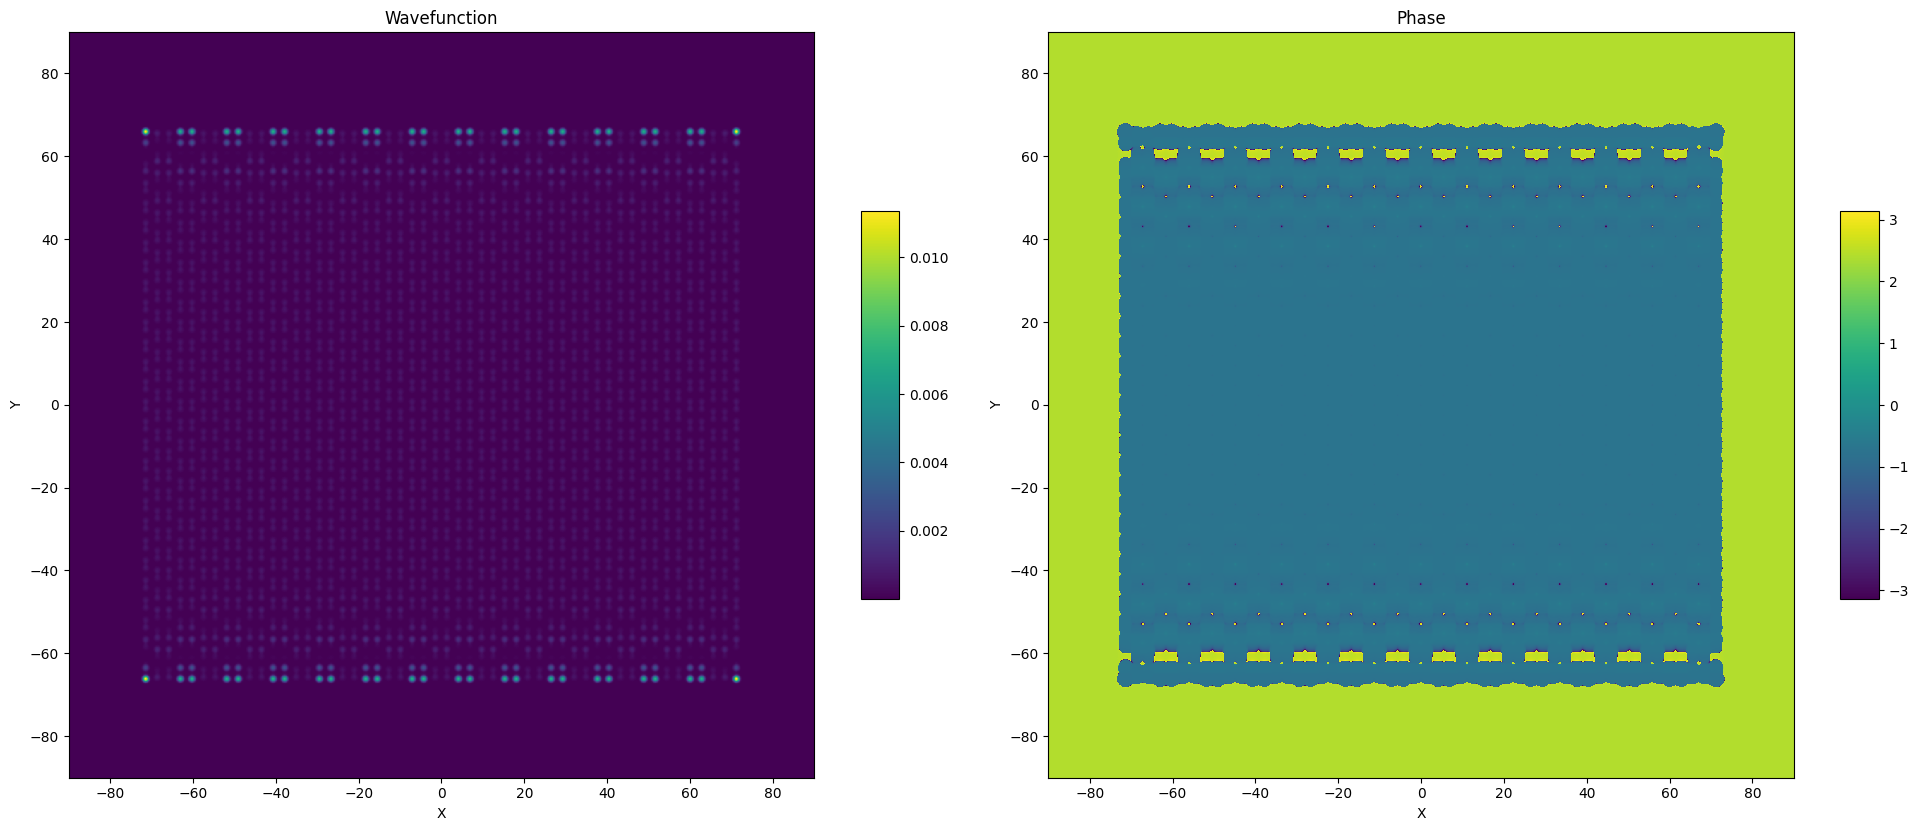

In [36]:
# Plot Results
data = np.loadtxt( os.path.join(result_path, "wavefunction_plus.txt") )
re,im = data[:grid_size,:], data[grid_size:,:]
psi = (re + 1j*im).reshape(grid_size,grid_size)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(X,Y,np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(X,Y,np.angle(psi))

for ax,plot in zip((ax1,ax2),(plt_psi,plt_phase)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

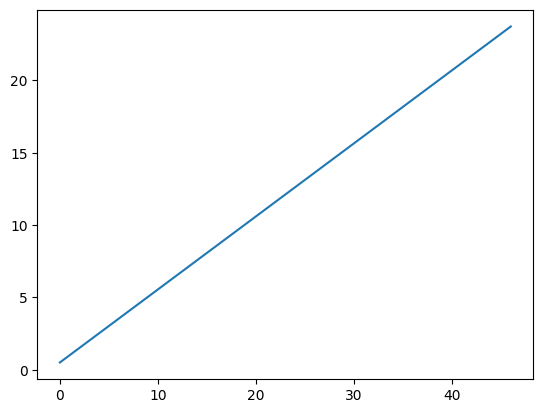

In [34]:
data_max = np.loadtxt( os.path.join(result_path, "max.txt"), unpack=True, comments="index" )

fig, ax = plt.subplots()
ax.plot(data_max[0], data_max[1])